<font face="helvetica" color=#3c734d size=6>**Recognizing Credit Card Fraud using Unsupervised Anomaly Detection**</font><br>
Notebook Authored by: Katie McQuinn
<br>
<br>
<font face="helvetica" color=#3c734d size=5>**Background**</font><br>
Anomaly detection refers to the process of identifying rare items, events, or observations which differ significantly from the majority of the data. These “outliers” may indicate critical incidents, such as fraudulent activity, structural defects, or cyber attacks.

In the context of credit card transactions, anomalies typically correspond to behavior that deviates from typical spending patterns. Because fraud is rare and varied in behavior, supervised learning may not generalize well, especially when new types of fraud emerge. That's where unsupervised learning comes in.
<br>
<br>
<font face="helvetica" size=4> Why Unsupervised? </font></br>
* <b>Label Scarcity</b>: Real-world fraud datasets often lack accurate or complete labels.

* <b>Class Imbalance</b>: Fraudulent transactions are extremely rare (usually <1%).

* <b>Adaptability</b>: Unsupervised models can detect unknown or evolving fraud patterns.
<br>

<font face="helvetica" color=#3c734d size=5>**Dataset Description**</font><br>
* <b>Source:</b> [Kaggle Credit Card Fraud Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)<br>
* <b>Size:</b> 284,807 Transactions in .csv<br>
* <b>Features:</b> 30 columns(V1-V28 from PCA, ```Time```, ```Amount```, & ```Class```)<br>
* <b>Target (for val. only):</b>```Class``` (0=typical, 1=fraud)<br>
<br>

<font face="Helvetica" size=4 color=#3c734d> Import Packages </font></br>

In [64]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             average_precision_score, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

<font face="helvetica" color=#3c734d size=5>**Exploratory Data Analysis**</font><br>


<font face="Helvetica" size=4 color=#3c734d> Load Data </font></br>

In [28]:
fraud_df = pd.read_csv("/content/drive/MyDrive/Data_Science/DTSA 5510: Unsupervised Learning/Anomaly Detection/creditcard.csv")

In [29]:
fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
fraud_df.isnull().sum().max()

0

No null values.

<font face="Helvetica" size=4 color=#3c734d> Preprocess Data </font></br>

In [31]:
scaler = StandardScaler()
fraud_df[["Time", "Amount"]] = scaler.fit_transform(fraud_df[["Time", "Amount"]])
X = fraud_df.drop(columns=["Class"])
y_true = fraud_df["Class"]
X_scaled = X.values

In [32]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [33]:
fraud_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [34]:
fraud_df["Class"].value_counts()

,count
Class,
0,284315
1,492


Wildly imbalanced dataset! We will use some techniques later on in this project to address that.

<font face="Helvetica" size=4 color=#3c734d> Visualize Data</font></br>

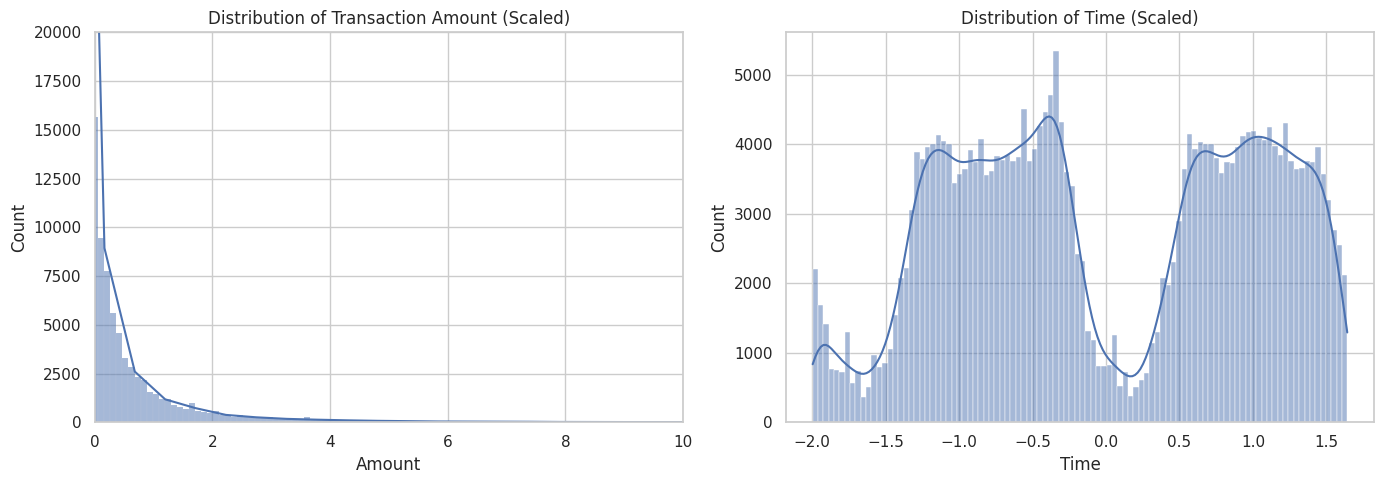

In [39]:
# Set up matplotlib style
sns.set(style="whitegrid")

# Distribution of Amount and Time (before scaling)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(fraud_df["Amount"], bins=1000, ax=axes[0], kde=True)
axes[0].set_title("Distribution of Transaction Amount (Scaled)" )
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0,20000)
sns.histplot(fraud_df["Time"], bins=100, ax=axes[1], kde=True)
axes[1].set_title("Distribution of Time (Scaled)")
plt.tight_layout()
plt.show()

Curious to see just how many rows have a transaction amount of 0 Dollars (1825). Code is below. It also looks like the vast majority of transactions are under $100.

As for the time distribution, it seems to be evenly distributed, i.e. no anomalous spikes in transactions.

In [40]:
# Curious to see just how many rows have a transaction amount of $0
(fraud_df['Amount'] == 0).sum()

np.int64(0)

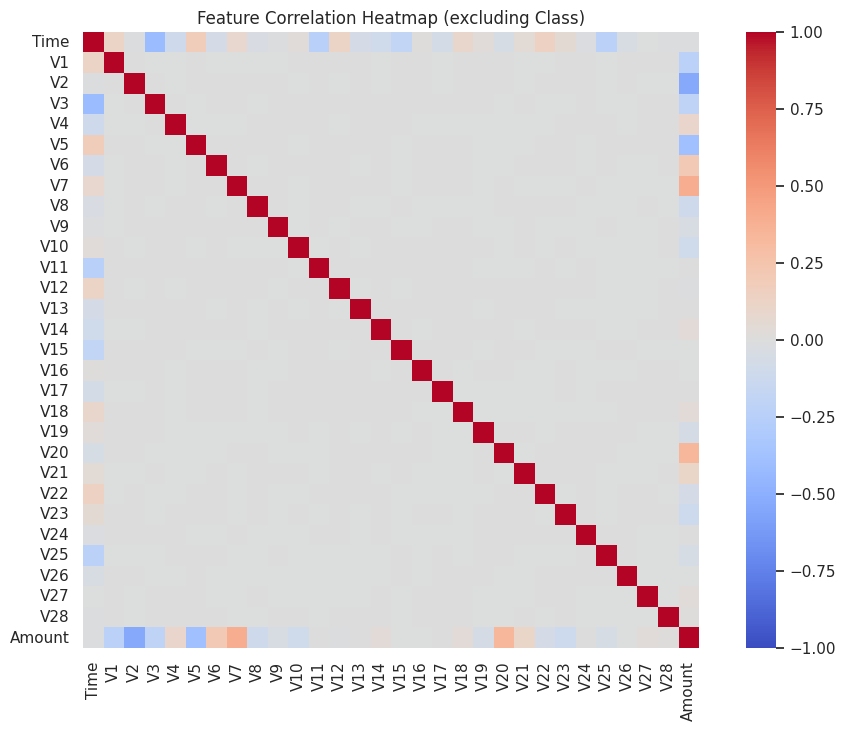

In [41]:
# Correlation heatmap
corr = fraud_df.drop(columns="Class").corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", vmax=1.0, vmin=-1.0, square=True, cbar=True)
plt.title("Feature Correlation Heatmap (excluding Class)")
plt.show()

**Correlation Heatmap**<br>
* Features seem to be decorrelated (expected from PCA)
* Reinforces the fact that we'll need to use models that assume independence.

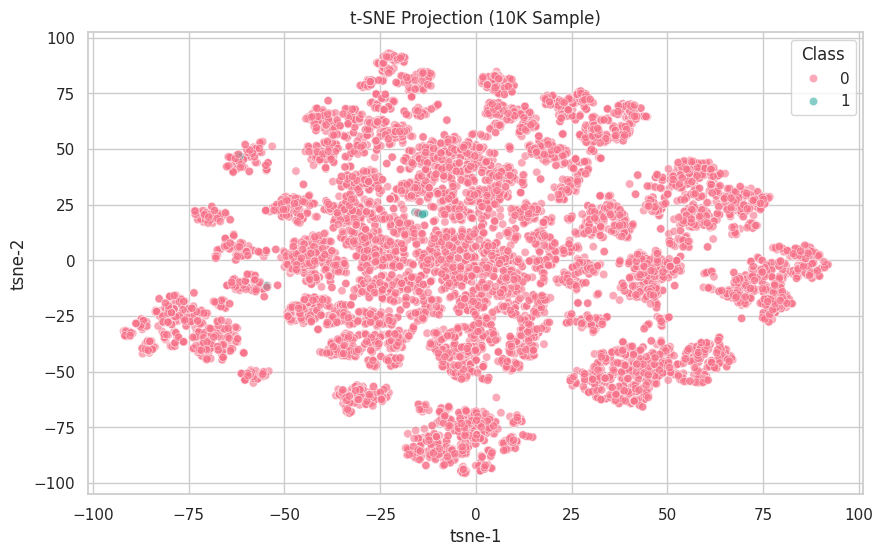

In [42]:
# TSNE visualization on a 10K sample
sample = fraud_df.sample(10000, random_state=42)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(sample.drop(columns="Class")))
sample["tsne-1"], sample["tsne-2"] = tsne_result[:, 0], tsne_result[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne-1", y="tsne-2", hue="Class", data=sample, palette="husl", alpha=0.6)
plt.title("t-SNE Projection (10K Sample)")
plt.grid(True)
plt.show()

Just a lil peek at distribution by class using t-SNE projection. This dataset will be good for anomaly detection because the fraud cases seem to cluster together. (Little blue spot in the center)

<font face="helvetica" color=#3c734d size=5>**Model Architecture**</font><br>
* We are going to use LSTM Autoencoder because it may be able to capture temporal dependencies
<br>
<br>



<font face="Helvetica" size=4 color=#3c734d> Model Evaluation Helper Function </font></br>

So that I can evaluate my models as we go.

In [60]:
def evaluate_model(name, y_true, y_pred, score=None):
    print(f"Evaluation: {name}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if score is not None:
        print(f"AUPRC: {average_precision_score(y_true, score):.4f}")
    else:
        print(f"AUPRC: {average_precision_score(y_true, y_pred):.4f}")

<font face="Helvetica" size=4 color=#3c734d> Model Plot Helper Function </font></br>

So that I can evaluate my models as we go.

In [56]:
def plot_model_results(y_true, score_dict, threshold_dict=None):
    """
    Plots precision-recall curves and prints AUPRC for multiple models.

    Parameters:
        y_true: array-like of true class labels (0 or 1)
        score_dict: dictionary with model name as key and anomaly scores as values
        threshold_dict: optional dictionary with thresholds used for binary predictions
    """
    plt.figure(figsize=(10, 7))

    for model_name, scores in score_dict.items():
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)
        plt.plot(recall, precision, label=f"{model_name} (AUPRC = {ap:.4f})")

        if threshold_dict and model_name in threshold_dict:
            # Plot point on PR curve corresponding to chosen threshold
            bin_pred = (scores > threshold_dict[model_name]).astype(int)
            p = precision_score(y_true, bin_pred)
            r = recall_score(y_true, bin_pred)
            plt.scatter(r, p, marker='x', s=100, label=f"{model_name} @ threshold")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for Anomaly Detection Models")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

<font face="Helvetica" size=4 color=#3c734d> Confusion Matrix Helper Function </font></br>

So that I can evaluate my models as we go.

In [57]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model", normalize=False):
    """
    Plots a confusion matrix for binary classification.

    Parameters:
        y_true (array-like): True binary labels (0 = normal, 1 = fraud)
        y_pred (array-like): Predicted binary labels
        model_name (str): Name of the model to display in the title
        normalize (bool): Whether to normalize counts to percentages
    """
    labels = ["Normal", "Fraud"]
    cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format=".2f" if normalize else "d")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.grid(False)
    plt.show()

<font face="helvetica" color=#3c734d size=5>**Model Building & Training**</font><br>

<font face="Helvetica" size=4 color=#3c734d> Build LSTM Autoencoder </font></br>

In [43]:
def build_lstm_autoencoder(timesteps, n_features, latent_dim=16):
    inputs = Input(shape=(timesteps, n_features))
    x = LSTM(latent_dim, activation='relu')(inputs)
    x = RepeatVector(timesteps)(x)
    outputs = LSTM(n_features, activation='relu', return_sequences=True)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

<font face="Helvetica" size=4 color=#3c734d> Train LSTM Autoencoder </font></br>

In [45]:
epochs = 50
batch_size = 128
validation_split = 0.1

X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

lstm_autoencoder = build_lstm_autoencoder(1, X_scaled.shape[1])
lstm_autoencoder.fit(X_lstm, X_lstm, epochs=epochs, batch_size=batch_size,
                     validation_split=validation_split, shuffle=True)

lstm_preds = lstm_autoencoder.predict(X_lstm)
lstm_errors = np.mean(np.square(X_lstm - lstm_preds), axis=(1, 2))
lstm_thresh = np.percentile(lstm_errors, 99.83)
fraud_df["lstm_pred"] = (lstm_errors > lstm_thresh).astype(int)

Epoch 1/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.8344 - val_loss: 0.5945
Epoch 2/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6522 - val_loss: 0.5718
Epoch 3/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6353 - val_loss: 0.5636
Epoch 4/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6314 - val_loss: 0.5611
Epoch 5/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6213 - val_loss: 0.5578
Epoch 6/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6452 - val_loss: 0.5569
Epoch 7/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6369 - val_loss: 0.5555
Epoch 8/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6220 - val_loss: 0.5547
Epoch 9/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6315 - val_loss: 0.5542
Epoch 10/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6314 - val_loss: 0.5531
Epoch 11/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6311 - val_loss: 0.5513
Epoch 12/50
2003/2003 ━━━━━━━

<font face="Helvetica" size=4 color=#3c734d> Evaluate LSTM Autoencoder </font></br>


📊 Evaluation: LSTM Autoencoder
Precision: 0.2433
Recall:    0.2398
F1 Score:  0.2416
AUPRC:     0.1886


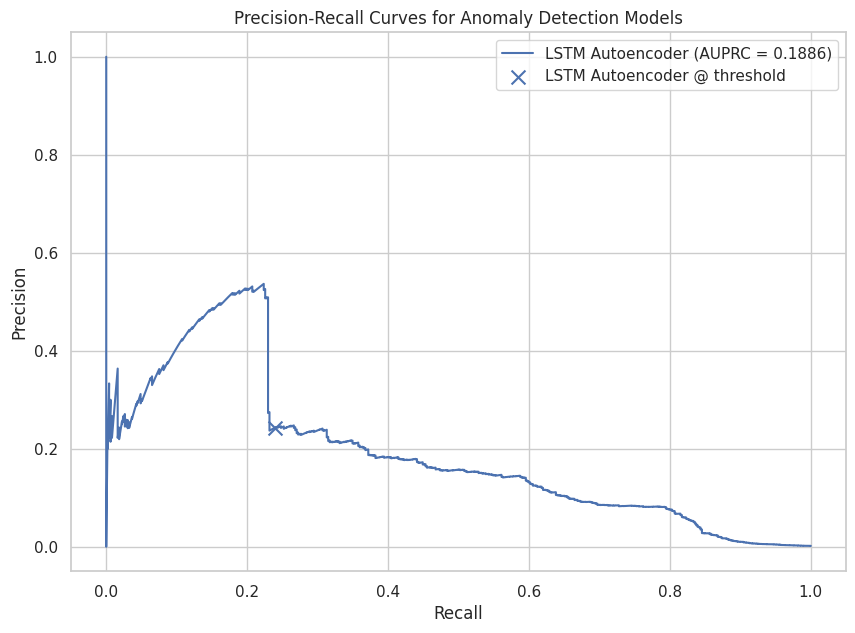

<Figure size 600x500 with 0 Axes>

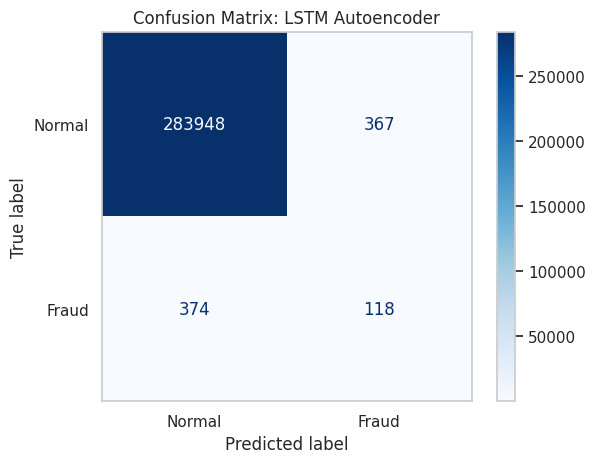

In [59]:
evaluate_model("LSTM Autoencoder", y_true, fraud_df["lstm_pred"], lstm_errors)

plot_model_results(
    y_true=y_true,
    score_dict={"LSTM Autoencoder": lstm_errors},
    threshold_dict={"LSTM Autoencoder": lstm_thresh}
)

plot_confusion_matrix(y_true, fraud_df["lstm_pred"],
                      model_name="LSTM Autoencoder")

First go around has less-than-ideal scores! I'm going to try to utilize a dense autoencoder to try to get some better results.

<font face="Helvetica" size=4 color=#3c734d> Build Dense Autoencoder </font></br>

In [61]:
def build_dense_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(input_dim, activation='linear')(x)
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

<font face="Helvetica" size=4 color=#3c734d> Train Dense Autoencoder </font></br>

In [48]:
epochs = 25
batch_size = 128
validation_split = 0.1

dense_autoencoder = build_dense_autoencoder(X_scaled.shape[1])
dense_autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size,
                      validation_split=validation_split, shuffle=True)

dense_preds = dense_autoencoder.predict(X_scaled)
dense_errors = np.mean(np.square(X_scaled - dense_preds), axis=1)
dense_thresh = np.percentile(dense_errors, 99.83)
fraud_df["dense_pred"] = (dense_errors > dense_thresh).astype(int)

Epoch 1/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.3905 - val_loss: 0.1065
Epoch 2/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0747 - val_loss: 0.0736
Epoch 3/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0587 - val_loss: 0.0638
Epoch 4/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0485 - val_loss: 0.0555
Epoch 5/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0438 - val_loss: 0.0593
Epoch 6/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0395 - val_loss: 0.0451
Epoch 7/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0356 - val_loss: 0.0413
Epoch 8/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0330 - val_loss: 0.0374
Epoch 9/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0313 - val_loss: 0.0375
Epoch 10/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0300 - val_loss: 0.0381
Epoch 11/25
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0286 - val_loss: 0.0390
Epoch 12/25
2003/2003 ━━━━━━━

<font face="Helvetica" size=4 color=#3c734d> Evaluate Dense Autoencoder </font></br>

Evaluation: Dense Autoencoder
Precision: 0.1670
Recall:    0.1646
F1 Score:  0.1658
AUPRC: 0.0938


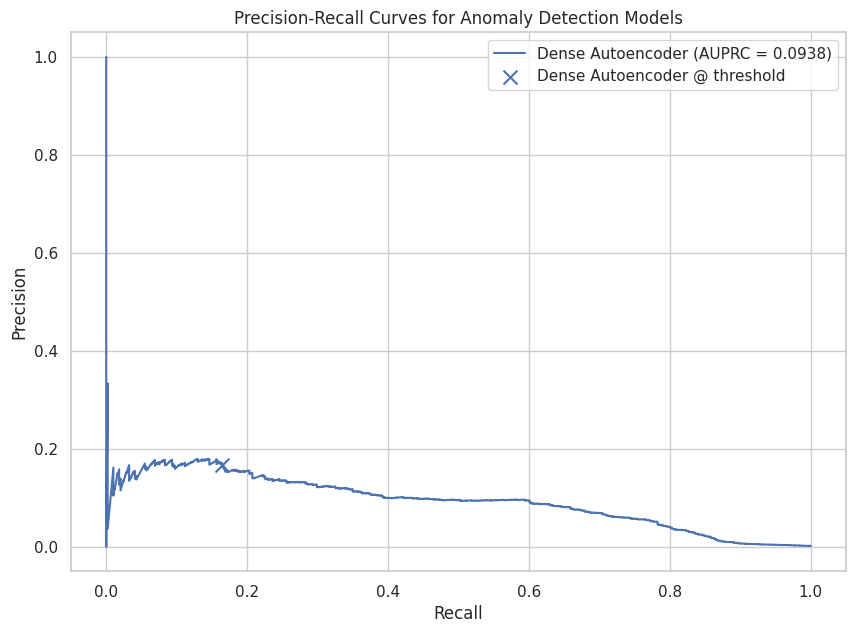

<Figure size 600x500 with 0 Axes>

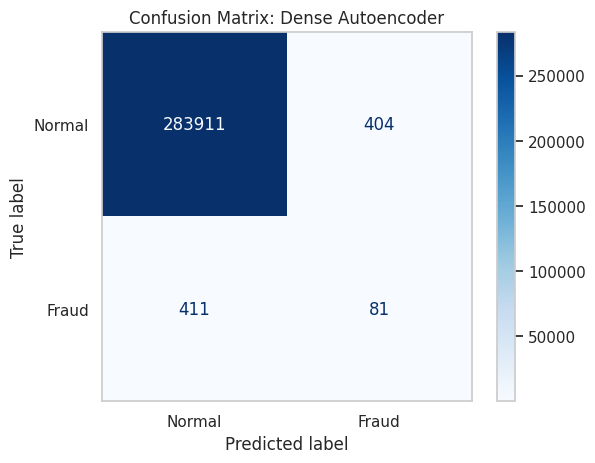

In [65]:
evaluate_model("Dense Autoencoder", y_true, fraud_df["dense_pred"], dense_errors)

plot_model_results(
    y_true=y_true,
    score_dict={"Dense Autoencoder": dense_errors},
    threshold_dict={"Dense Autoencoder": dense_thresh}
)

plot_confusion_matrix(y_true, fraud_df["dense_pred"],
                      model_name="Dense Autoencoder")

I will now up the epochs to 50 and add early stopping.

<font face="Helvetica" size=4 color=#3c734d> Re-train Dense Autoencoder </font></br>

In [76]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7, restore_best_weights=True)

epochs = 50
batch_size = 128
validation_split = 0.1

dense_autoencoder = build_dense_autoencoder(X_scaled.shape[1])
dense_autoencoder.fit(X_scaled, X_scaled, epochs=epochs,
                      batch_size=batch_size,
                      validation_split=validation_split,
                      callbacks=[early_stopping],
                      shuffle=True)

dense_preds = dense_autoencoder.predict(X_scaled)
dense_errors = np.mean(np.square(X_scaled - dense_preds), axis=1)
dense_thresh = np.percentile(dense_errors, 99.83)
fraud_df["dense_pred"] = (dense_errors > dense_thresh).astype(int)

Epoch 1/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4257 - val_loss: 0.1126
Epoch 2/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0914 - val_loss: 0.0747
Epoch 3/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0596 - val_loss: 0.0594
Epoch 4/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0494 - val_loss: 0.0519
Epoch 5/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0443 - val_loss: 0.0485
Epoch 6/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0387 - val_loss: 0.0410
Epoch 7/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0358 - val_loss: 0.0408
Epoch 8/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0344 - val_loss: 0.0408
Epoch 9/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0320 - val_loss: 0.0388
Epoch 10/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 11/50
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0287 - val_loss: 0.0367
Epoch 12/50
2003/2003 ━━━━━━━━

<font face="Helvetica" size=4 color=#3c734d> Re-evaluate Dense Autoencoder </font></br>

Evaluation: Dense Autoencoder
Precision: 0.1464
Recall:    0.1443
F1 Score:  0.1453
AUPRC: 0.0782


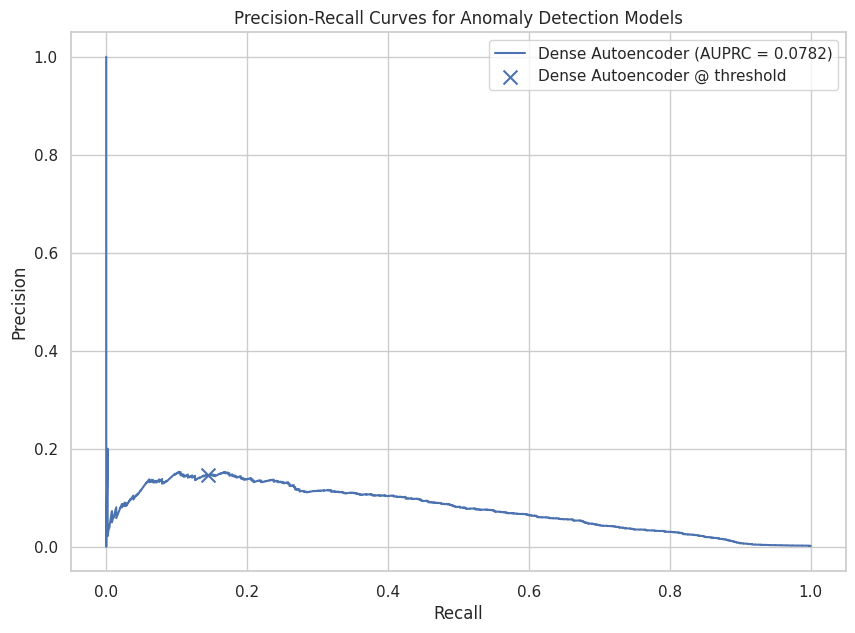

<Figure size 600x500 with 0 Axes>

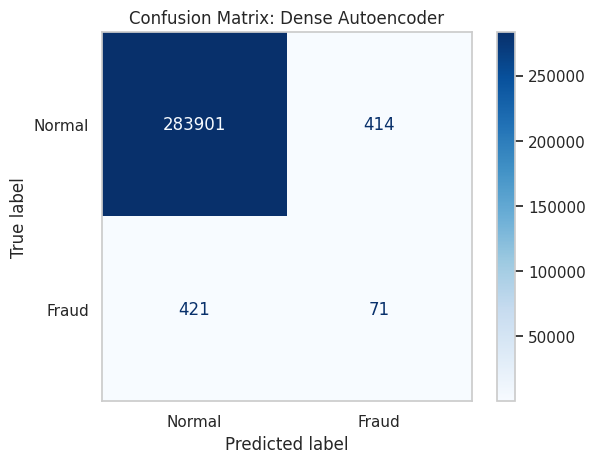

In [77]:
evaluate_model("Dense Autoencoder", y_true, fraud_df["dense_pred"], dense_errors)

plot_model_results(
    y_true=y_true,
    score_dict={"Dense Autoencoder": dense_errors},
    threshold_dict={"Dense Autoencoder": dense_thresh}
)

plot_confusion_matrix(y_true, fraud_df["dense_pred"],
                      model_name="Dense Autoencoder")

Somehow even worse scores.

<font face="Helvetica" size=4 color=#3c734d> Build One-Class SVM </font></br>

In [90]:
svm = OneClassSVM(kernel='rbf', nu=0.0017, gamma=0.01)

<font face="Helvetica" size=4 color=#3c734d> Train One-Class SVM </font></br>

In [91]:
svm.fit(X_scaled)

svm_scores = -svm.decision_function(X_scaled)  # Higher score = more anomalous
svm_preds = (svm.predict(X_scaled) == -1).astype(int)  # -1 = anomaly → 1

<font face="Helvetica" size=4 color=#3c734d> Evaluate One-Class SVM </font></br>

Evaluation: One-Class SVM
Precision: 0.1431
Recall:    0.1585
F1 Score:  0.1504
AUPRC: 0.0657


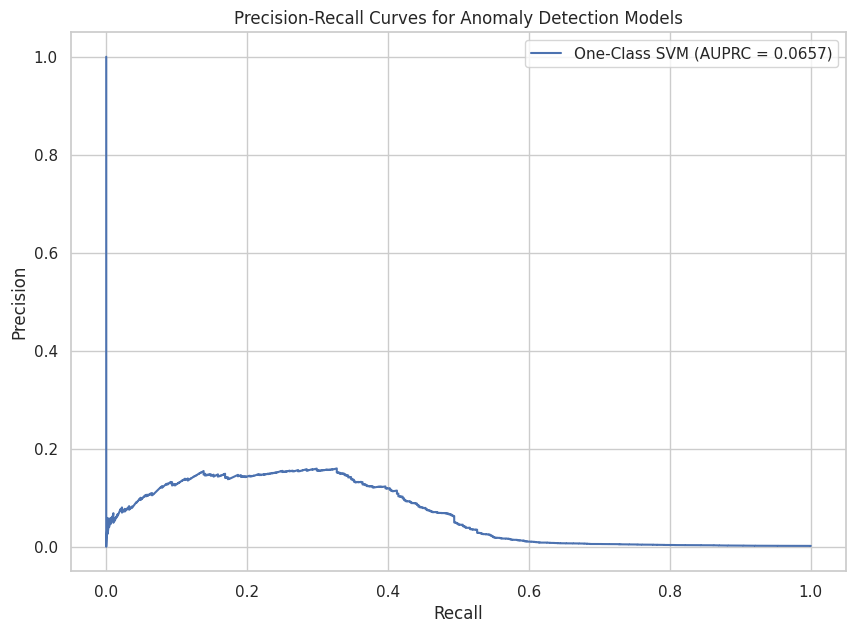

<Figure size 600x500 with 0 Axes>

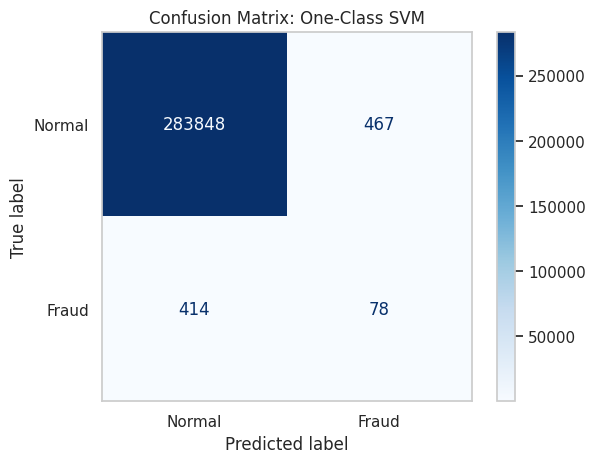

In [92]:
evaluate_model("One-Class SVM", y_true, fraud_df["svm_pred"], score=svm_scores)

plot_model_results(
    y_true=y_true,
    score_dict={"One-Class SVM": svm_scores}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=svm_preds,
    model_name="One-Class SVM"
)

This model performed worse than the other two. I'll do some hyperparameter tuning before moving on.

<font face="Helvetica" size=4 color=#3c734d> Re-Build One-Class SVM </font></br>

Just changed **gamma** from `0.01` -> `0.001`.

In [81]:
svm = OneClassSVM(kernel='rbf', nu=0.0017, gamma=0.001)

<font face="Helvetica" size=4 color=#3c734d> Re-Train One-Class SVM </font></br>

In [82]:
svm.fit(X_scaled)

svm_scores = -svm.decision_function(X_scaled)  # Higher score = more anomalous
svm_preds = (svm.predict(X_scaled) == -1).astype(int)  # -1 = anomaly → 1

<font face="Helvetica" size=4 color=#3c734d> Re-Evaluate One-Class SVM </font></br>

Evaluation: One-Class SVM
Precision: 0.2144
Recall:    0.2114
F1 Score:  0.2129
AUPRC: 0.0733


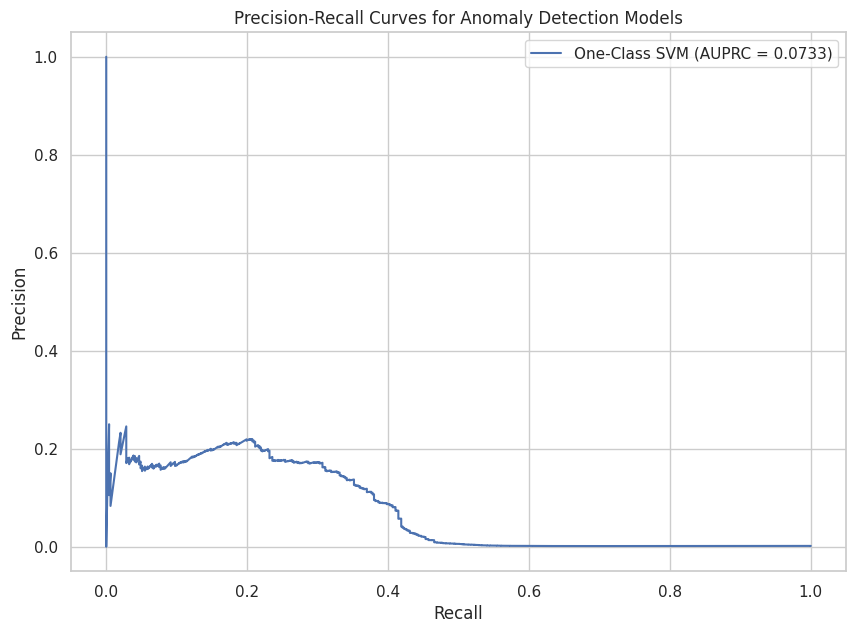

<Figure size 600x500 with 0 Axes>

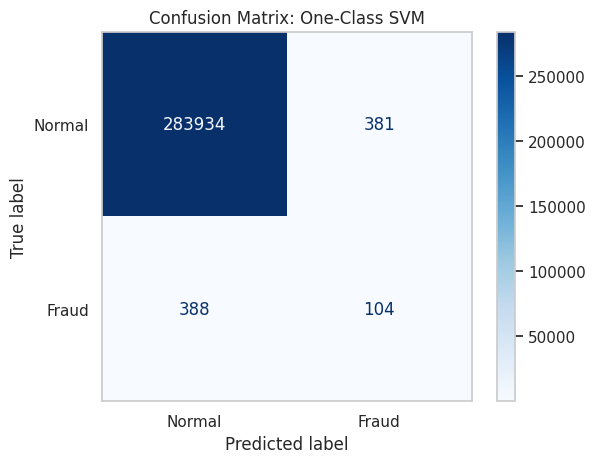

In [88]:
evaluate_model("One-Class SVM", y_true, svm_preds, score=svm_scores)

plot_model_results(
    y_true=y_true,
    score_dict={"One-Class SVM": svm_scores}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=svm_preds,
    model_name="One-Class SVM"
)

The One-Class SVM rebuild/retrain performed a little bit better but still not excellent. Let me try Isolation Forest.

<font face="Helvetica" size=4 color=#3c734d> Build Isolation Forest </font></br>

In [93]:
n_estimators = 200
contamination = 0.0017
max_samples = 10000


iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             random_state=42,
                             max_samples=max_samples)

<font face="Helvetica" size=4 color=#3c734d> Train Isolation Forest </font></br>

In [94]:
iso_forest.fit(X_scaled)

iso_preds = iso_forest.predict(X_scaled)
fraud_df["iso_pred"] = (iso_preds == -1).astype(int)
fraud_df["iso_score"] = -iso_forest.decision_function(X_scaled)

<font face="Helvetica" size=4 color=#3c734d> Evaluate Isolation Forest </font></br>

Evaluation: Isolation Forest
Precision: 0.3072
Recall:    0.3028
F1 Score:  0.3050
AUPRC: 0.2392


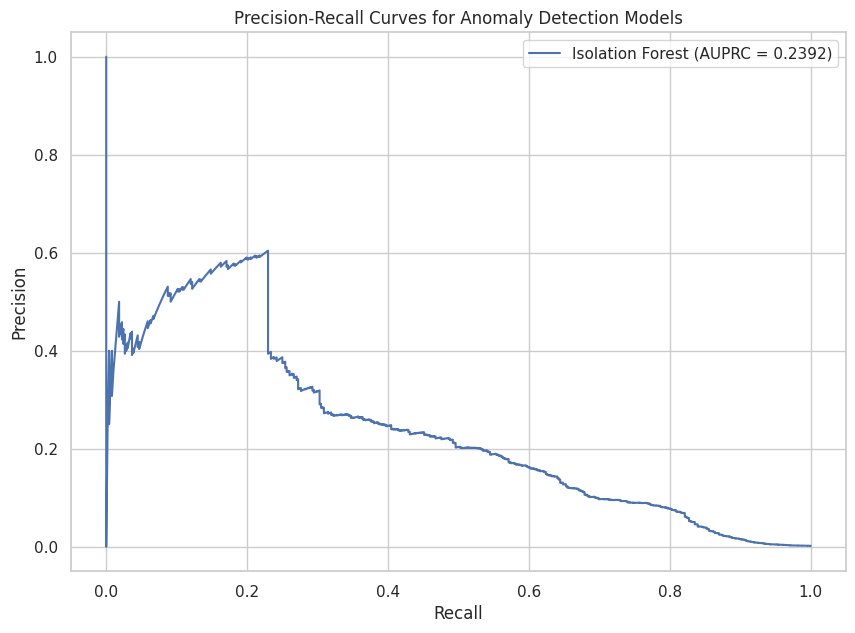

<Figure size 600x500 with 0 Axes>

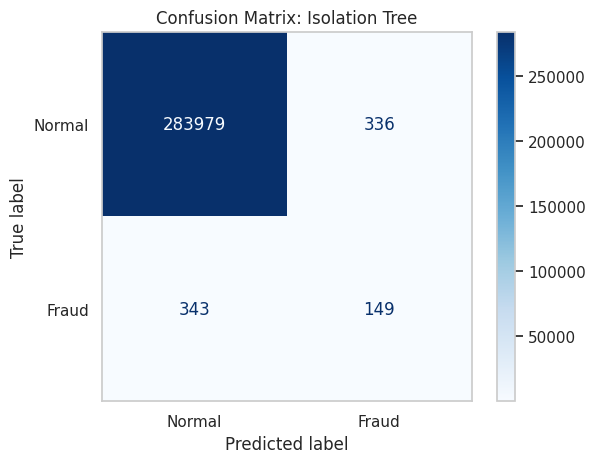

In [96]:
evaluate_model("Isolation Forest", y_true, fraud_df["iso_pred"], fraud_df["iso_score"])

plot_model_results(
    y_true=y_true,
    score_dict={"Isolation Forest": fraud_df["iso_score"]}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=fraud_df["iso_pred"],
    model_name="Isolation Tree"
)

While the isolation forest model doesn't seem to perform <i>excellently</i>, it has the highest AUPRC `0.2392` out of all four models that I tried. Let's see if we can make it even better.

<font face="Helvetica" size=4 color=#3c734d> Re-Build Isolation Forest (tuning n_estimators) </font></br>

Let's try increasing the `n_estimators` from `200` -> `300`

In [131]:
n_estimators = 300
contamination = 0.0017
max_samples = 10000


iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             random_state=42,
                             max_samples=max_samples)

<font face="Helvetica" size=4 color=#3c734d> Re-Train Isolation Forest (tuning n_estimators)</font></br>

In [132]:
iso_forest.fit(X_scaled)

iso_preds = iso_forest.predict(X_scaled)
fraud_df["iso_pred"] = (iso_preds == -1).astype(int)
fraud_df["iso_score"] = -iso_forest.decision_function(X_scaled)

<font face="Helvetica" size=4 color=#3c734d> Re-Evaluate Isolation Forest (tuning n_estimators)</font></br>

Evaluation: Isolation Forest
Precision: 0.3072
Recall:    0.3028
F1 Score:  0.3050
AUPRC: 0.2352


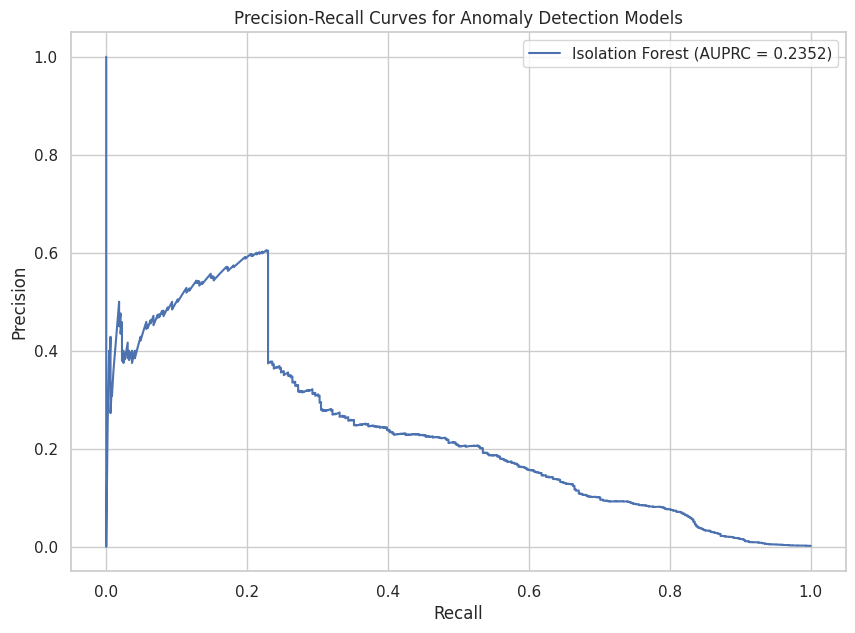

<Figure size 600x500 with 0 Axes>

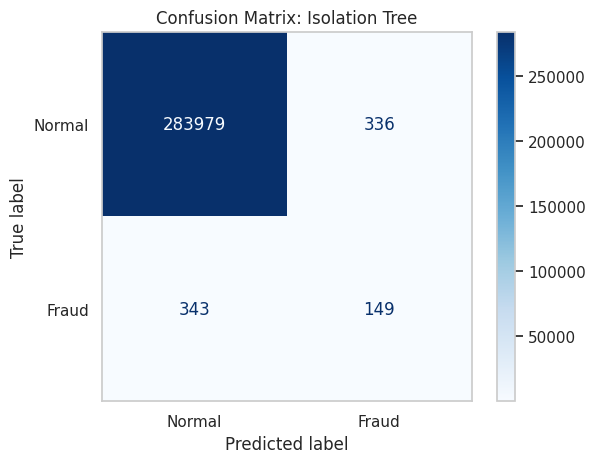

In [133]:
evaluate_model("Isolation Forest", y_true, fraud_df["iso_pred"], fraud_df["iso_score"])

plot_model_results(
    y_true=y_true,
    score_dict={"Isolation Forest": fraud_df["iso_score"]}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=fraud_df["iso_pred"],
    model_name="Isolation Tree"
)

When I increased the `n_estimators`, my `AUPRC` score went down a little bit. `0.2392`-> `0.2352`. Let's try again but instead, *decrease* the `n_estimators`

<font face="Helvetica" size=4 color=#3c734d> Re-Build Isolation Forest (tuning n_estimators)</font></br>

Let's try increasing the `n_estimators` from `200` -> `95`

In [150]:
n_estimators = 95
contamination = 0.0017
max_samples = 10000


iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             random_state=42,
                             max_samples=max_samples)

<font face="Helvetica" size=4 color=#3c734d> Re-Train Isolation Forest (tuning n_estimators) </font></br>

In [151]:
iso_forest.fit(X_scaled)

iso_preds = iso_forest.predict(X_scaled)
fraud_df["iso_pred"] = (iso_preds == -1).astype(int)
fraud_df["iso_score"] = -iso_forest.decision_function(X_scaled)

<font face="Helvetica" size=4 color=#3c734d> Re-Evaluate Isolation Forest (tuning n_estimators)</font></br>

Evaluation: Isolation Forest
Precision: 0.3093
Recall:    0.3049
F1 Score:  0.3071
AUPRC: 0.2595


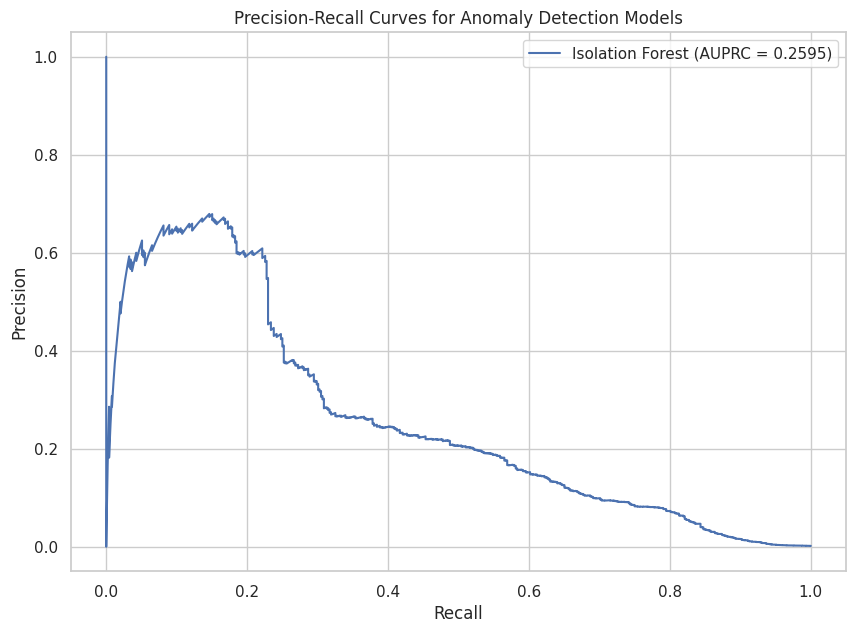

<Figure size 600x500 with 0 Axes>

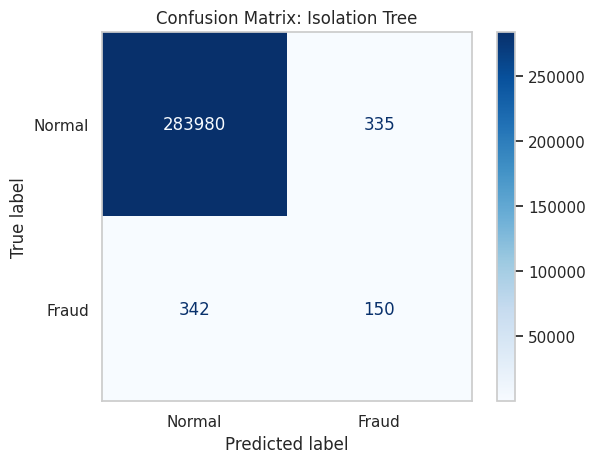

In [152]:
evaluate_model("Isolation Forest", y_true, fraud_df["iso_pred"], fraud_df["iso_score"])

plot_model_results(
    y_true=y_true,
    score_dict={"Isolation Forest": fraud_df["iso_score"]}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=fraud_df["iso_pred"],
    model_name="Isolation Tree"
)

After decreasing the `n_estimators` from `200`-> `95`, we got a slight `AUPRC` score increase. `0.2392` -> `0.2595`. This is not a significant shift, but I'll stop here.

<font face="Helvetica" size=4 color=#3c734d> Re-Build Isolation Forest (tuning contamination)</font></br>

Let's try increasing the `contamination` from `0.0017` -> `0.003`

In [147]:
n_estimators = 95
contamination = 0.003
max_samples = 10000


iso_forest = IsolationForest(n_estimators=n_estimators,
                             contamination=contamination,
                             random_state=42,
                             max_samples=max_samples)

<font face="Helvetica" size=4 color=#3c734d> Re-Train Isolation Forest </font></br>

In [148]:
iso_forest.fit(X_scaled)

iso_preds = iso_forest.predict(X_scaled)
fraud_df["iso_pred"] = (iso_preds == -1).astype(int)
fraud_df["iso_score"] = -iso_forest.decision_function(X_scaled)

<font face="Helvetica" size=4 color=#3c734d> Re-Evaluate Isolation Forest </font></br>

Evaluation: Isolation Forest
Precision: 0.2386
Recall:    0.4146
F1 Score:  0.3029
AUPRC: 0.2392


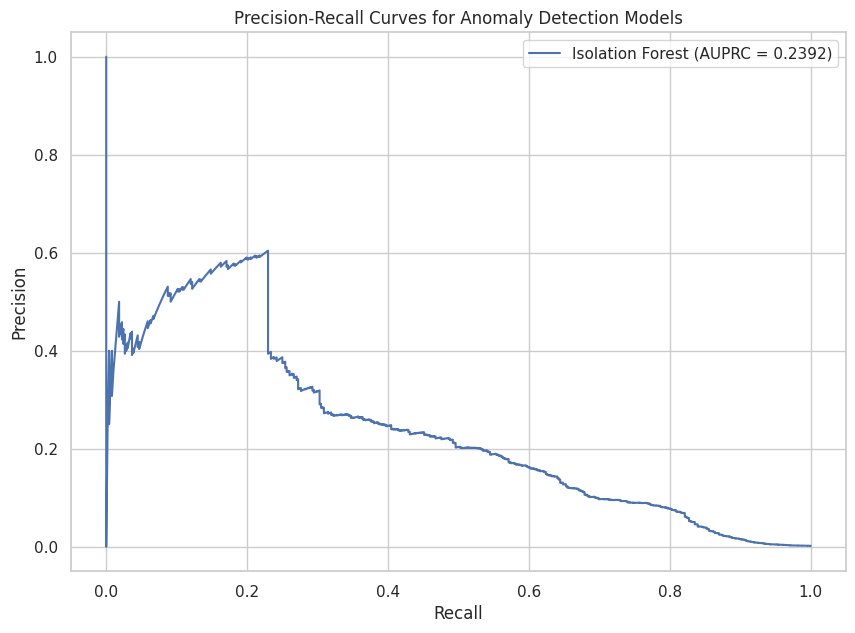

<Figure size 600x500 with 0 Axes>

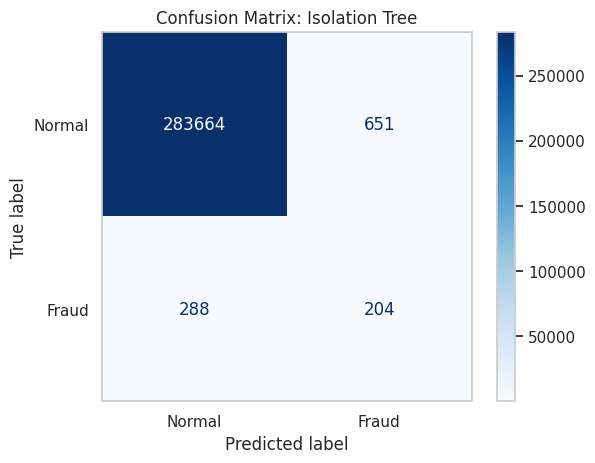

In [149]:
evaluate_model("Isolation Forest", y_true, fraud_df["iso_pred"], fraud_df["iso_score"])

plot_model_results(
    y_true=y_true,
    score_dict={"Isolation Forest": fraud_df["iso_score"]}
)

plot_confusion_matrix(
    y_true=y_true,
    y_pred=fraud_df["iso_pred"],
    model_name="Isolation Tree"
)

As you can see, by increasing the `contamination`, the recall score goes way up but the precision goes down. That is because we are widening the margin for what we consider a fraudulent transaction. There is an argument to be had about prioritizing recall over precision in cases like these. That is, catching *more* of the fraudulent cases means that you also will mark more legitimate purchase as fraud. The other option, by decreasing the `contamination` we will get fewer legitmate purchases classified as fraud but may end up missing much more of the fraudulent cases. This is an issue for a banking domain expert to decide!

For now, I will evaluate the best versions of each of my four models.

<font face="helvetica" color=#3c734d size=5>**Model Evaluation**</font><br>

<font face="Helvetica" size=4 color=#3c734d> AUPRC Evaluation Metrics </font></br>


I'm using Area Under the Precision-Recall Curve (AUPRC) to evaluate my models. This is a reasonable evaluation metric for this imbalanced dataset.
<br>
<br>
I will use these score scales as follows:
<br>

AUPRC Score|Details
----|----
**0.01-0.05**|catches more fraud than random (0.017)
**0.05-0.2** |solid score for unsupervised modeling
**0.2-0.5**|excellent for anomaly detection
**>0.5**|exceptional & rare


In [153]:
evaluate_model("LSTM Autoencoder", y_true, fraud_df["lstm_pred"], lstm_errors)

Evaluation: LSTM Autoencoder
Precision: 0.2433
Recall:    0.2398
F1 Score:  0.2416
AUPRC: 0.1886


In [154]:
evaluate_model("Dense Autoencoder", y_true, fraud_df["dense_pred"], dense_errors)

Evaluation: Dense Autoencoder
Precision: 0.1464
Recall:    0.1443
F1 Score:  0.1453
AUPRC: 0.0782


In [155]:
evaluate_model("One-Class SVM", y_true, fraud_df["svm_pred"])

Evaluation: One-Class SVM
Precision: 0.1431
Recall:    0.1585
F1 Score:  0.1504
AUPRC: 0.0241


In [156]:
evaluate_model("Isolation Forest", y_true, fraud_df["iso_pred"], fraud_df["iso_score"])

Evaluation: Isolation Forest
Precision: 0.3093
Recall:    0.3049
F1 Score:  0.3071
AUPRC: 0.2595


As you can see, the Isolation Forest performed the best out of all iterations of four models. The best scores of each model are below:

Model|AUPRC|Precision|Recall|F1
---|---|---|---|---
LSTM Autoencoder|0.1886|0.2433|0.2398|0.2416
Dense Autoencoder|0.0782|0.1464|0.1443|01453
One-Class SVM|0.0241|0.1431|0.1585|0.1504
Isolation Tree|**0.2595**|0.3093|0.3049|0.3071

<font face="helvetica" color=#3c734d size=5>**Discussion**</font><br>

This project explored unsupervised anomaly detection techniques to detect fraudulent credit card transactions in a highly imbalanced dataset.
**Four** models were implemented:
* LSTM Autoencoder
* Dense Autoencoder
* One-Class SVM
* Isolation Forest

Given the nature of fraud detection — where labeled data is sparse and fraudulent behaviors constantly evolve — unsupervised methods offer a promising alternative to traditional supervised classification.

A key challenge of this project was the extreme class imbalance (only **0.17%** of transactions were fraud), which required evaluation metrics beyond standard accuracy.

**Area Under the Precision-Recall Curve (AUPRC)** was chosen as the primary metric, as it better reflects model performance under imbalance.

Among the four models:

* **The LSTM Autoencoder** was initially promising, capturing sequential transaction patterns, but required careful threshold tuning to balance precision and recall.

* **The Dense Autoencoder**, while faster to train, suffered from underfitting, even with added layers and early stopping.

* **The One-Class SVM** underperformed, likely due to poor scalability in high-dimensional space and sensitivity to hyperparameters.

* **The Isolation Forest**, a tree-based ensemble model that isolates anomalies through recursive partitioning, consistently outperformed the others. With tuned hyperparameters (`n_estimators=95`, `contamination=0.0017`), it achieved the best balance of precision and recall, with an AUPRC of `0.2595` — over 150x better than random guessing (baseline ≈ `0.0017`).

In tuning, it was observed that:

Increasing contamination improved recall at the cost of precision — a useful tradeoff when the goal is flagging as many frauds as possible. I still did not deem that my most successful model.

Decreasing n_estimators slightly improved AUPRC, possibly due to overfitting avoidance in deeper forests.

<font face="helvetica" color=#3c734d size=5>**Conclusion**</font><br>

Unsupervised anomaly detection offers a viable path for identifying credit card fraud when labeled data is limited or evolving. Through a combination of dimensionality-aware preprocessing, model-specific tuning, and appropriate evaluation metrics, the Isolation Forest model emerged as the most effective for this dataset.

However, no model is perfect. Isolation Forest missed many fraudulent transactions (`recall < 0.31`) and flagged some legitimate ones. This reflects a broader tension in fraud detection: catching more frauds vs. minimizing false positives — a business tradeoff that depends on the domain context.

In future work, combining models in an ensemble or incorporating semi-supervised methods (e.g. using a small labeled subset) could yield even better results. Additional features like user behavior or merchant patterns would also improve detection quality.

Overall, this project demonstrates that with thoughtful tuning and evaluation, unsupervised learning can meaningfully detect rare anomalies — and even outperform naive supervised baselines — in real-world fraud scenarios.